In [ ]:
from fastai.vision.all import *
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
top_edge = tensor([[-1,-1,-1],
 [ 0, 0, 0],
 [ 1, 1, 1]]).float()

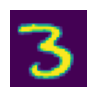

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [ ]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [ ]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [ ]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [ ]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [ ]:
def apply_kernel(row, col, kernal):
    return (im3_t[row-1:row+2,col-1:col+2] * kernal).sum()
apply_kernel(5, 7, top_edge)

tensor(762.)

In [ ]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

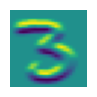

In [ ]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

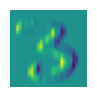

In [ ]:
left_edge = tensor([[-1,1,0],
 [-1,1,0],
 [-1,1,0]]).float()
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

In [ ]:
diag1_edge = tensor([[ 0,-1, 1],
 [-1, 1, 0],
 [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
 [ 0, 1,-1],
 [ 0, 0, 1]]).float()
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [ ]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
 get_items=get_image_files,
 splitter=GrandparentSplitter(),
 get_y=parent_label)
dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [ ]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [ ]:
edge_kernels = edge_kernels.unsqueeze(1)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

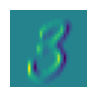

In [ ]:
show_image(batch_features[0,0]);

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
    nn.ReLU(),
    nn.Conv2d(16,16,kernel_size=3,stride=2,padding=1),
)

In [ ]:
broken_cnn(xb).shape

torch.Size([64, 16, 7, 7])

In [ ]:
def conv(ni, nf, ks=3, act=True):
 res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
 if act: res = nn.Sequential(res, nn.ReLU())
 return res

In [ ]:
simple_cnn = sequential(
 conv(1 ,4), #14x14
 conv(4 ,8), #7x7
 conv(8 ,16), #4x4
 conv(16,32), #2x2
 conv(32,2, act=False), #1x1
 Flatten(),
)

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.070008,0.045121,0.985770,00:21
1,0.024351,0.028687,0.992149,00:19


In [ ]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [ ]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [ ]:
m[0].bias.shape

torch.Size([4])

In [ ]:
! wget https://bearizona.com/wp-content/uploads/2022/09/GD3A0309-1024x683.webp

--2024-12-22 08:45:07--  https://bearizona.com/wp-content/uploads/2022/09/GD3A0309-1024x683.webp
Resolving bearizona.com (bearizona.com)... 104.19.154.92
Connecting to bearizona.com (bearizona.com)|104.19.154.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75258 (73K) [image/webp]
Saving to: ‘GD3A0309-1024x683.webp’

GD3A0309-1024x683.w 100%[===================>]  73.49K  --.-KB/s    in 0.02s   

2024-12-22 08:45:07 (3.33 MB/s) - ‘GD3A0309-1024x683.webp’ saved [75258/75258]



In [ ]:
im = image2tensor(Image.open('/content/GD3A0309-1024x683.webp'))
im.shape

torch.Size([3, 683, 1024])

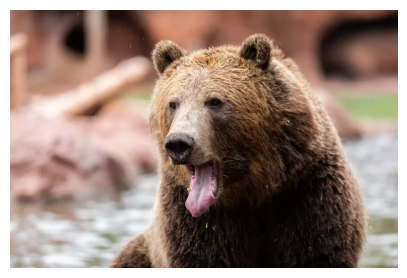

In [ ]:
show_image(im);

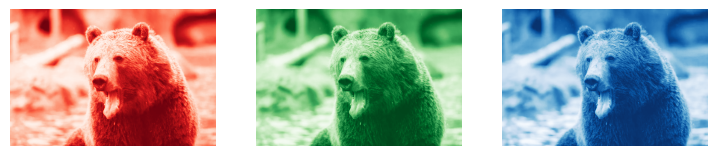

In [ ]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
 show_image(255-bear, ax=ax, cmap=color)

In [ ]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [ ]:
def get_dls(bs=64):
 return DataBlock(
 blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
 get_items=get_image_files,
 splitter=GrandparentSplitter('training','testing'),
 get_y=parent_label,
 batch_tfms=Normalize()
 ).dataloaders(path, bs=bs)
dls = get_dls()

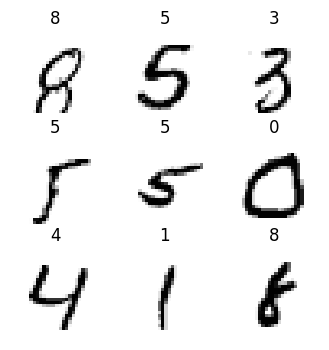

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
def simple_cnn():
 return sequential(
 conv(1 ,8, ks=5), #14x14
 conv(8 ,16), #7x7
 conv(16,32), #4x4
 conv(32,64), #2x2
 conv(64,10, act=False), #1x1
 Flatten(),
 )

In [ ]:
from fastai.callback.hook import *

In [ ]:
def fit(epochs=1):
 learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
 metrics=accuracy, cbs=ActivationStats(with_hist=True))
 learn.fit(epochs, 0.06)
 return learn
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.310097,2.303860,0.100900,02:01


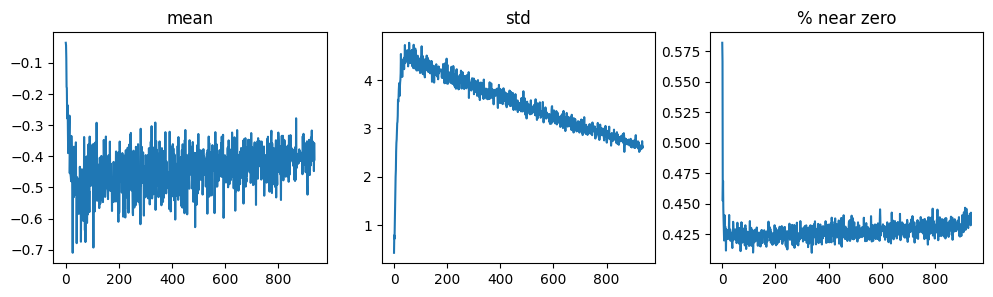

In [ ]:
learn.activation_stats.plot_layer_stats(0)

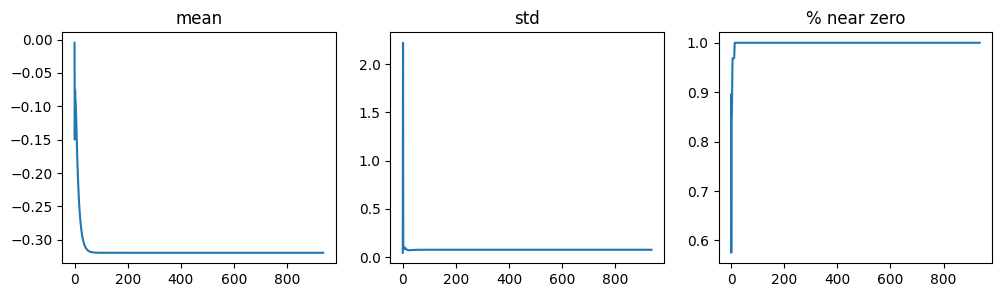

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.327821,2.301423,0.113500,01:27


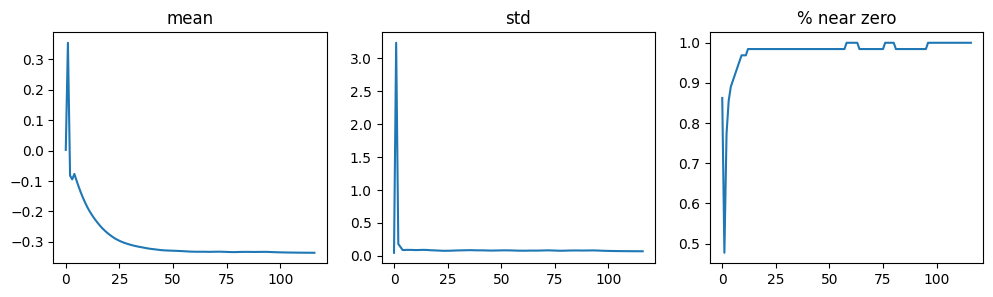

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
def fit(epochs=1, lr=0.06):
 learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
 metrics=accuracy, cbs=ActivationStats(with_hist=True))
 learn.fit_one_cycle(epochs, lr)
 return learn
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.203074,0.070685,0.977600,01:35


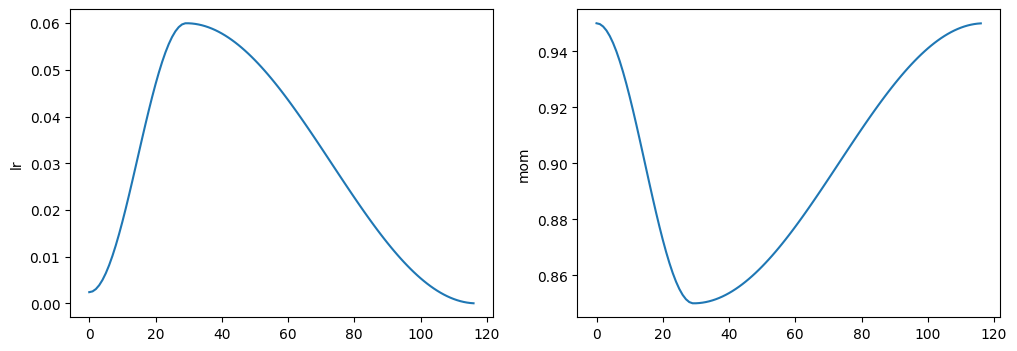

In [ ]:
learn.recorder.plot_sched()

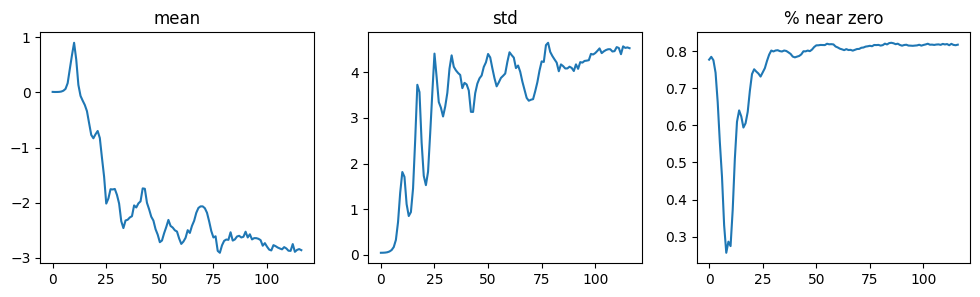

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

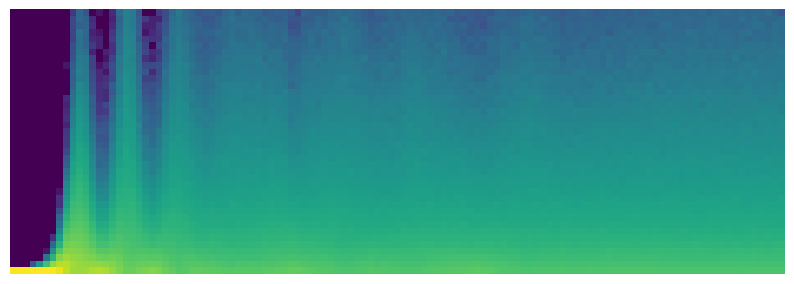

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
def conv(ni, nf, ks=3, act=True):
 layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
 layers.append(nn.BatchNorm2d(nf))
 if act: layers.append(nn.ReLU())
 return nn.Sequential(*layers)

In [ ]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.125811,0.053683,0.986600,01:33


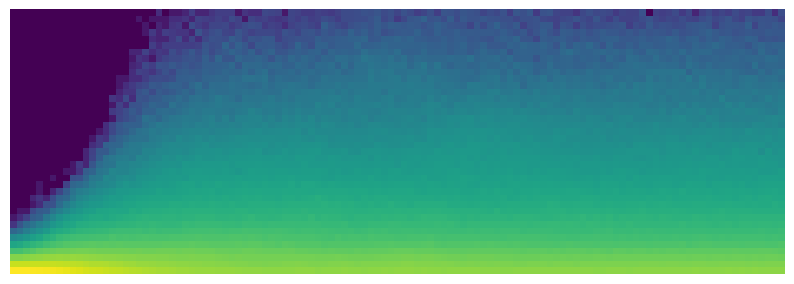

In [ ]:
learn.activation_stats.color_dim(-4)

In [ ]:
learn = fit(6, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.199497,0.232310,0.932200,01:26
1,0.085903,0.085504,0.973200,01:27
2,0.057671,0.051533,0.984000,01:24
3,0.041752,0.040653,0.987600,01:24
4,0.025511,0.027784,0.991900,01:25
5,0.012496,0.021263,0.993300,01:24
